# Learning parameters

Apziva project #3<br>
2023 07 17

__Summary:__
* Here __k and bonus__ are considered as __hyperparameters__.
* These hyperparameters are submitted to a grid-search.
* As a success metric, __delta__ is used, calculated as:
    * mean fitness of starred candidates 
    * mean fitness of the rest.
    * difference of the two.

## TOC: <a class="anchor" id="TOC"></a>
* [Notebook description](#NotebookDescription)
* [Utilities](#Utilities)
* [General settings](#GeneralSetting)
* [Functions used for learning steps](#FunctionsUsedForLearningSteps)
* [Fine-tuning parameters](#FineTuningParameters)
    * [Summary of manual process](#SummaryOfManualProcess)
    * [Grid-search](#GridSearch)
    * [Summary of optimized process](#SummaryOfOptimezedProcess)

## Notebook description <a class="anchor" id="NotebookDescription"></a>
[TOC](#TOC)

* In this notebook, the learning parameters __k__ and __bonus__ are fine-tuned.
* The delta from the last notebook shall be used as the success metric:
    * `delta = fitness`<sub>`starred`</sub>` - fitness`<sub>`not starred`</sub>
* This fine-tuning process will vary for the varying manual learning processes:
    * Yet, robust values for __k__ and __bonus__ shall be identified.

## Utilities <a class="anchor" id="Utilities"></a>
[TOC](#TOC)

In [1]:
# own libraries
import Utilities as u
import MachineLearning as ml

# activate changes in libraries
import importlib
importlib.reload(u)
importlib.reload(ml)

# aliases
from Utilities import TypeChecker as t
from Utilities import PrintAlias as p

## General settings <a class="anchor" id="GeneralSetting"></a>
[TOC](#TOC)

In [2]:
# constants

# general
cfltRandomSeed = 42 # any number

# files
cstrSourcePath = "../data/raw/"
cstrSourceFile = "PotentialTalentsUTF8.csv"

cstrOutputPath = "../data/interim/"
cstrOutputFile = "RankedCandidates.csv"

## Functions used for learning steps <a class="anchor" id="FunctionsUsedForLearningSteps"></a>
[TOC](#TOC)

In [3]:
from pathlib import Path

In [4]:
def JoinNumbers(varListOrSet, strSeparator=", "):
    '''
    Generalized function to join lists and sets of numbers, as the base function "join" works only with strings and with lists.
    
    When       Who What
    2023 07 20 dh  Created
    '''
    
    # convert to list of numbers
    if isinstance(varListOrSet, list):
        lvarNumbers = varListOrSet.copy()
    elif isinstance(varListOrSet, set):
        lvarNumbers = list(varListOrSet.copy())
    else:
        p("Strange data type in function JoinNumbers")
        return

    # convert to list of strings
    lstrNumbers = [str(varNumber) for varNumber in lvarNumbers]

    # join
    return strSeparator.join(lstrNumbers)

if False:
    lintNumbers = [1, 2, 3, 4, 5]
    sfltNumbers = set([1, 2, 3, 4, 5.555])
    p("List of integers:",JoinNumbers(lintNumbers))
    p("Set of floats:",JoinNumbers(sfltNumbers))

In [5]:
def AdjustAsProbabilities(dfrSource, strColumn):
    '''
    Normalizes column strColumn to values from 0 to 1.
    
    When       Who What
    2023 07 19 dh  Created
    '''
    fltMaximum = dfrSource[strColumn].max()
    dfrSource[strColumn] = dfrSource[strColumn].apply(lambda x: x / fltMaximum if fltMaximum != 0 else 0)

def UpdateFitnessFromStar(dfrStarred,intStarredId,fltBonus = 0.30):
    '''
    Adds a bonus to the starred candidate and re-adjusts the probabilities to the range 0 to 1.
    
    When       Who What
    2023 07 19 dh  Created
    '''    
    dfrUpdatedFitness = dfrStarred.copy()
    dfrUpdatedFitness.loc[dfrUpdatedFitness['id'] == intStarredId, 'fit'] += fltBonus
    AdjustAsProbabilities(dfrUpdatedFitness,"fit")
    return dfrUpdatedFitness

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
def UpdateFitnessFromKNN(dfrFitnessOriginal,dfrBonusAdjustedFitness,intK = 2):
    '''
    Trains a KNN model and applies it back on the training dataset
    
    When       Who What
    2023 07 19 dh  Created
    '''  
    
    # init
    dfrUpdated = dfrFitnessOriginal.copy()
    
    # transfer bonus from starring
    dfrUpdated = dfrUpdated.merge(dfrBonusAdjustedFitness[['id', 'fit']], on='id', suffixes=('', '_bonus'))
    dfrUpdated['fit'] = dfrUpdated['fit_bonus']
    dfrUpdated.drop('fit_bonus', axis=1, inplace=True)

    # create X and y
    lstrFeatureColumns = ["connection"] + dfrUpdated.filter(regex=r'^L_').columns.tolist()
    strTargetColumn = "fit"
    X = dfrUpdated[lstrFeatureColumns]
    y = dfrUpdated[strTargetColumn]
    
    # scale
    objStandardScaler = StandardScaler()
    objStandardScaler.fit(X)
    X_scaled = objStandardScaler.transform(X)
    
    # train KNN model
    objKNN = KNeighborsRegressor(n_neighbors=intK)
    objKNN.fit(X_scaled, y)

    # re-fit training data
    a1fltAdjustedFitnessValues = objKNN.predict(X_scaled)
    dfrUpdated[strTargetColumn] = a1fltAdjustedFitnessValues
    dfrUpdated.sort_values(strTargetColumn,ascending=False)
    
    # finalize
    return dfrUpdated

In [7]:
def SuccessReport(lintStarredCandidates,dfrSortedFitness, blnVerbose=False):
    '''
    Evaluates if starring had a positive effect:
    - 100%: all candidates starred in the past are on top.
    -   0%: none of the starred candidates is on top.
    
    When       Who What
    2023 07 20 dh  Created
    '''    
        
    # init
    sintStarredCandidates = set(lintStarredCandidates)
    intStarredWithoutDuplicates = len(sintStarredCandidates)
    dfrTop = dfrSortedFitness.copy()
    
    # get top candidates
    dfrTop = dfrTop.head(intStarredWithoutDuplicates)
    srsMatchingRecords = dfrTop['id'].isin(sintStarredCandidates)
    intStarredCandidatesOnTop = srsMatchingRecords.sum()
    fltPortionOnTop = intStarredCandidatesOnTop/intStarredWithoutDuplicates
    
    # get mean fitness of... 
    srsMaskStarredCandidates = dfrSortedFitness['id'].isin(sintStarredCandidates)
    
    # ... starred candidates
    dfrFilteredRecords = dfrSortedFitness.loc[srsMaskStarredCandidates]
    fltMeanFitnessStarred = dfrFilteredRecords['fit'].mean()
    
    # ... candidates never starred
    dfrFilteredRecords = dfrSortedFitness.loc[~srsMaskStarredCandidates]
    fltMeanFitnessNotStarred = dfrFilteredRecords['fit'].mean()
    fltDelta = fltMeanFitnessStarred - fltMeanFitnessNotStarred

    # report
    if blnVerbose:
        p("Success report".upper())
        p(f"- starring events so far:")
        p(f"  - all:                {len(lintStarredCandidates)}, i.e. { JoinNumbers(lintStarredCandidates,' ')}")
        p(f"  - without duplicates: {intStarredWithoutDuplicates}, i.e. {JoinNumbers(sintStarredCandidates,' ')}")
        p(f"- starred candidates on top:")
        p(f"  - count:              {intStarredCandidatesOnTop}")
        p(f"  - portion:            {round(100 * fltPortionOnTop)}%")
        p(f"- mean fitness:")
        p(f"  - starred:            {round(100 * fltMeanFitnessStarred,1)}%")
        p(f"  - rest:               {round(100 * fltMeanFitnessNotStarred,1)}%")
        p(f"  - delta:              {round(100 * fltDelta,1)}%")
        
    # finalize
    return fltDelta

In [8]:
import matplotlib.pyplot as plt

def DrawLineChart(lfltValues, strTitle, intAdjustX = 1):
    '''
    Draws a line chart from float values.
    
    When       Who What
    2023 07 22 dh  Created
    '''      
    # creater x values artifically
    lintX = list(range(len(lfltValues)))
    lintX = [intX+intAdjustX for intX in lintX] # start at 1 rather than 0
    
    # line chart
    plt.plot(lintX, lfltValues, 
             marker='o', linestyle='-', 
             color='orange', markerfacecolor='orange', markeredgecolor='black')
    
    # explanations
    plt.title(strTitle)
    plt.xlabel('Learning step')
    plt.ylabel('Delta')
    if False:
        plt.ylim(0.2, 0.6)
    
    # finalize
    plt.show()

In [9]:
import seaborn as sns
def DrawHeatMap(dfrResults, strColumnX, strColumnY, strColumnZ):
    '''
    Draws a heat map.
    
    When       Who What
    2023 07 22 dh  Created
    '''      
    # pivot dataframe for heatmap
    dfrHeatMapData = dfrResults.pivot(strColumnX, strColumnY, strColumnZ)

    # create heatmap
    strColorMap = 'plasma'
    fltWidth  = 5.0
    fltHeight = 3.5
    plt.figure(figsize=(fltWidth, fltHeight))
    sns.heatmap(dfrHeatMapData, annot=True, cmap=strColorMap, fmt=".2f", linewidths=0.5)

    # heatmap denominations
    plt.title(f"Heatmap of '{strColumnZ}' values for '{strColumnX}' and '{strColumnY}'")
    plt.xlabel(strColumnY)
    plt.ylabel(strColumnX)
    
    # finalize
    plt.show()

In [10]:
def RunHistory(intK=2,fltBonus=0.30, blnVerboseDetail=False, blnVerboseFinal=False, blnVerboseTopTen=False):
    '''
    Runs entire manual learning history automatically.
    
    When       Who What
    2023 07 22 dh  Created
    '''          
    # init
    dfrFitnessFromLearning = u.FromDisk("dfrFitnessFromScoring","model")
    lintStarredCandidates = u.FromDisk("lintStarredCandidates","models")
    lfltDeltas = []
    
    # apply each manual starring event, now automatically
    for intLearningEvent,intStarredCandidate in enumerate(lintStarredCandidates):
        
        # apply bonus
        dfrUpdatedFitnessFromStar = dfrFitnessFromLearning.copy()
        dfrUpdatedFitnessFromStar.loc[dfrUpdatedFitnessFromStar['id'] == intStarredCandidate, 'fit'] += fltBonus
        AdjustAsProbabilities(dfrUpdatedFitnessFromStar,"fit")
        
        # apply KNN model
        dfrFitnessFromLearning = UpdateFitnessFromKNN(dfrFitnessFromLearning,dfrUpdatedFitnessFromStar, intK)
        dfrFitnessFromLearning.sort_values("fit",ascending=False,inplace=True)
        
        # calculate success metric
        fltDelta = SuccessReport(lintStarredCandidates,dfrFitnessFromLearning, blnVerbose=False)
        lfltDeltas.append(fltDelta)
        
        if blnVerboseDetail:
            p(f"Learning event: {intLearningEvent}")
            p(f"- ID:           {intStarredCandidate}")
            p(f"- delta:        {round(100*fltDelta,1)}%")

    # reports
    if blnVerboseFinal:
        fltDeltaRounded = round(100*fltDelta,1)
        p(f"- k:       {intK}")
        p(f"- bonus:   {fltBonus}")
        p(f"- starred: {JoinNumbers(lintStarredCandidates,' ')}")
        p(f"- delta:   {fltDeltaRounded}%")
        strTitle = "Development of delta".upper()
        DrawLineChart(lfltDeltas,f"{strTitle}\nk={intK}, bonus={fltBonus}\nfinal delta={fltDeltaRounded}%")
        
    if blnVerboseTopTen:
        p("Top Ten".upper())
        pd.set_option('display.max_colwidth', 170)
        u.DisplayDataFrame(dfrFitnessFromLearning.head(10)[["id","job_title","location","connection","fit"]])       
        pd.reset_option('display.max_colwidth')

    # finalize
    # - return last delta
    return lfltDeltas[-1]

REPEAT MANUAL LEARNING PROCESS
- k:       2
- bonus:   0.3
- starred: 53 40 10 62 67 68 71
- delta:   42.1%


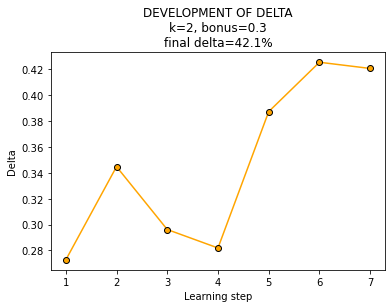

GRID SEARCH ON LEARNING PARAMETERS
- Top example: k=1, bonus=0.7, delta=65.3%
- Top 12 examples:


,k,bonus,delta
6,1.0,0.7,0.653192
5,1.0,0.6,0.652500
4,1.0,0.5,0.649395
3,1.0,0.4,0.641084
2,1.0,0.3,0.579805
1,1.0,0.2,0.530854
0,1.0,0.1,0.462739
26,4.0,0.6,0.461827
25,4.0,0.5,0.443366
10,2.0,0.4,0.439080


COMPARISON OF GRID-SEARCH PARAMETERS


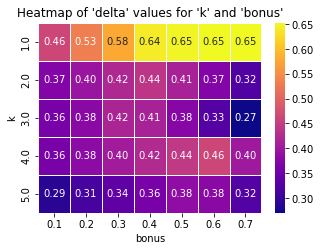

REPEAT LEARNING PROCESS FOR OPTIMUM
- k:       1
- bonus:   0.7
- starred: 53 40 10 62 67 68 71
- delta:   65.3%


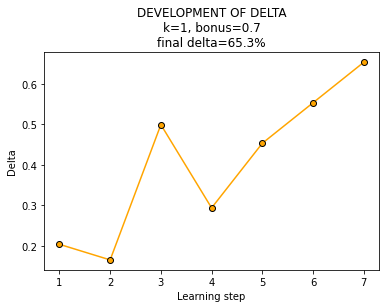

TOP TEN


,id,job_title,location,connection,fit
0,67,"Human resources, staffing and recruiting professional","Jackson, Mississippi Area",500,1.000000
60,71,"Human resources generalist at scottmadden, inc.","Raleigh-Durham, North Carolina Area",500,0.829322
1,68,Human resources specialist at luxottica,Greater New York City Area,500,0.829322
2,10,Seeking human resources HRIS and generalist positions,Greater Philadelphia Area,500,0.677325
3,62,Seeking human resources HRIS and generalist positions,Greater Philadelphia Area,500,0.677325
4,53,Seeking human resources HRIS and generalist positions,Greater Philadelphia Area,500,0.677325
5,40,Seeking human resources HRIS and generalist positions,Greater Philadelphia Area,500,0.677325
6,100,"Aspiring human resources manager, graduating may 2020, seeking an entry-level human resources position in st. louis","Cape Girardeau, Missouri",103,0.323305
11,70,"Retired army national guard recruiter, office manager, seeking a position in human resources.","Virginia Beach, Virginia",82,0.258644
12,27,Aspiring human resources management student seeking an internship,"Houston, Texas Area",500,0.258644


In [11]:
import pandas as pd

# manual process
p("Repeat manual learning process".upper())
RunHistory(blnVerboseDetail=False, blnVerboseFinal=True)

# find optimum by grid-search...
p("Grid search on learning parameters".upper())
lintK = [1,2,3,4,5]
lfltBonuses = [0.1,0.2,0.3,0.4,0.5,0.6,0.7]

# ... dataframe to collect results
dfrResults = pd.DataFrame(columns=["k", "bonus", "delta"]) 

# ... try combinations of k and bonus
for intK in lintK:
    for fltBonus in lfltBonuses:
        fltDelta = RunHistory(intK,fltBonus)
        dvarNewResult = {"k": intK, "bonus": fltBonus, "delta": fltDelta}
        dfrResults = dfrResults.append(dvarNewResult, ignore_index=True)

# ... show results numerically    
dfrResults.sort_values("delta", ascending=False, inplace=True)
cintExamples = 12
srsBest = dfrResults.iloc[0] # top record
p(f"- Top example: k={round(srsBest['k'])}, bonus={round(srsBest['bonus'],2)}, delta={round(100*srsBest['delta'],1)}%")
p(f"- Top {cintExamples} examples:")
u.DisplayDataFrame(dfrResults.head(cintExamples))

# ... and as a heatmap
p("Comparison of grid-search parameters".upper())
DrawHeatMap(dfrResults,"k","bonus","delta")

# history of optimum
p("Repeat learning process for optimum".upper())
fltDelta = RunHistory(intK=round(srsBest['k']),fltBonus=srsBest['bonus'], blnVerboseDetail=False, blnVerboseFinal=True, blnVerboseTopTen=True)